In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
# Use Inspector to print the column names and types
print('_______________')
print('Measurement Keys')
print('_______________')
for c in columns:
    print(c['name'], c["type"])

print('_______________')
print('Station Keys')
print('_______________')
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c['type'])

_______________
Measurement Keys
_______________
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
_______________
Station Keys
_______________
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

### Find out information on precipitation across the last year.

In [11]:
# Find the latest date in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

This is a method to make the pandas dataframe using sqlAlchemy

In [12]:
#find all of the dates for the last year of measurement in the table. 
precipitation = session.query(Measurement.prcp, Measurement.date).\
                             filter(Measurement.date > "2016-08-23" ).order_by(Measurement.date).all()
#make a pandas series to store all those values in.
rain_df = pd.DataFrame(zip(*precipitation), index=['prcp','date']).transpose().set_index('date')
rain_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,None
2016-08-24,1.22


This is an alternate method which uses a pandas function to read in the sql.

In [13]:
rain_df = pd.read_sql('SELECT date, prcp FROM measurement WHERE date > "2016-08-23" ORDER BY date', engine.connect()).set_index('date')
rain_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<AxesSubplot:xlabel='date', ylabel='Precipitation(inches)'>

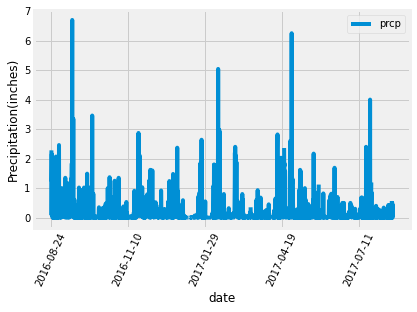

In [14]:
#Make a plot of the precipitation levels
rain_df.plot(kind='line', rot=65, ylabel='Precipitation(inches)')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_df = pd.read_sql('SELECT * FROM station',engine.connect())
len(station_df)

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#I could do this using pandas, but for the purpose of this exercise I will use an sqlalchemy query.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                                            group_by(Measurement.station).\
                                            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
climate_summary = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
                                group_by(Measurement.station).\
                                filter(Measurement.station == active_stations[0][0]).all()
climate_summary

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
paradise_year = session.query(Measurement.tobs).\
                                filter(Measurement.station == active_stations[0][0]).\
                                filter(Measurement.date > "2016-08-23" ).order_by(Measurement.date).all()
par_df = pd.DataFrame(data=paradise_year)

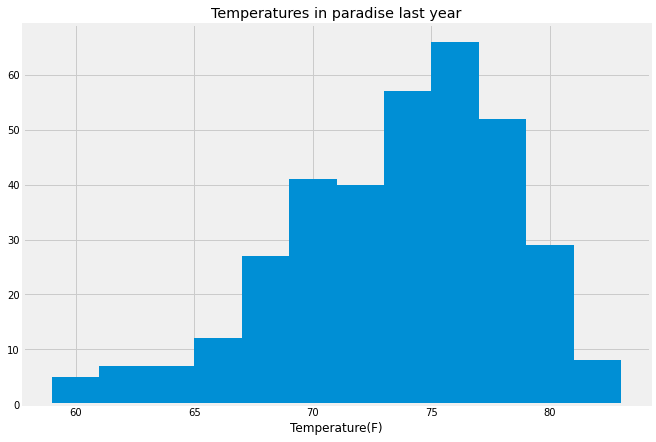

In [42]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Temperatures in paradise last year')
ax.set_xlabel('Temperature(F)')
n, bins, patches = ax.hist(par_df, 12)
plt.show()